Import all the necessary packages here:

In [18]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

Read the dataset:

In [19]:
data_frame = pd.read_csv("../main_datasets/sarcasm_data.csv")
data_frame.head()

,Unnamed: 0.1,Unnamed: 0,label,comment,votes,sentiment
0,0,0,0,NC and NH.,-1,0
1,1,1,0,You do know west teams play against west teams...,-1,1
2,2,2,0,"They were underdogs earlier today, but since G...",3,0
3,3,3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,4,4,0,I could use one of those tools.,-1,1


Select only the relevant columns

In [20]:
data_frame = data_frame[["label", "comment", "votes", "sentiment"]]
data_frame.head()

,label,comment,votes,sentiment
0,0,NC and NH.,-1,0
1,0,You do know west teams play against west teams...,-1,1
2,0,"They were underdogs earlier today, but since G...",3,0
3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,0,I could use one of those tools.,-1,1


Let's perform some data preprocessing:

In [21]:
def preprocess(text):
    return simple_preprocess(text, deacc=True, min_len=2, max_len=15)

data_frame['preprocessed_text'] = data_frame['comment'].apply(preprocess)
data_frame.head()

,label,comment,votes,sentiment,preprocessed_text
0,0,NC and NH.,-1,0,"[nc, and, nh]"
1,0,You do know west teams play against west teams...,-1,1,"[you, do, know, west, teams, play, against, we..."
2,0,"They were underdogs earlier today, but since G...",3,0,"[they, were, underdogs, earlier, today, but, s..."
3,0,"This meme isn't funny none of the ""new york ni...",-1,0,"[this, meme, isn, funny, none, of, the, new, y..."
4,0,I could use one of those tools.,-1,1,"[could, use, one, of, those, tools]"


Training the Word2Vec model:

In [22]:
embedding_size = 100
word2vec_model = Word2Vec(data_frame['preprocessed_text'], vector_size=embedding_size, window=5, min_count=2, workers=4)
word2vec_model

Let's create the word embeddings using the preprocessed_text feature:

In [23]:
def text_to_embedding(text):
    words = [word for word in text if word in word2vec_model.wv]
    if words:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.zeros(embedding_size)

data_frame['embedding'] = data_frame['preprocessed_text'].apply(text_to_embedding)

In [24]:
data_frame.head()

,label,comment,votes,sentiment,preprocessed_text,embedding
0,0,NC and NH.,-1,0,"[nc, and, nh]","[0.17858987, 0.41418445, -0.43662965, 0.451787..."
1,0,You do know west teams play against west teams...,-1,1,"[you, do, know, west, teams, play, against, we...","[-0.5764634, -0.4960394, -0.4277706, 0.1538956..."
2,0,"They were underdogs earlier today, but since G...",3,0,"[they, were, underdogs, earlier, today, but, s...","[-0.32324764, -0.32274923, -0.14285506, -0.057..."
3,0,"This meme isn't funny none of the ""new york ni...",-1,0,"[this, meme, isn, funny, none, of, the, new, y...","[-0.11412669, -0.8315491, 0.4286227, 0.1935356..."
4,0,I could use one of those tools.,-1,1,"[could, use, one, of, those, tools]","[-0.35948157, -0.6044432, -0.06033826, 0.20653..."


Split the data into Training and Test sets.

In [25]:
embedding_df = pd.DataFrame(data_frame['embedding'].tolist())
expanded_df = pd.concat([data_frame.drop('embedding', axis=1), embedding_df], axis=1)
X = expanded_df.drop('label', axis=1)
y = expanded_df['label']
print(X)
print(y)



                                                   comment  votes  sentiment  \
0                                               NC and NH.     -1          0   
1        You do know west teams play against west teams...     -1          1   
2        They were underdogs earlier today, but since G...      3          0   
3        This meme isn't funny none of the "new york ni...     -1          0   
4                          I could use one of those tools.     -1          1   
...                                                    ...    ...        ...   
1010768  I'm sure that Iran and N. Korea have the techn...      2          0   
1010769                 whatever you do, don't vote green!      1          1   
1010770  Perhaps this is an atheist conspiracy to make ...      1          1   
1010771  The Slavs got their own country - it is called...      1          1   
1010772  values, as in capitalism .. there is good mone...      2          1   

                                       

In [26]:
X = X.drop(columns=["comment", "preprocessed_text"])
X.columns = X.columns.astype(str)
X

,votes,sentiment,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,-1,0,0.178590,0.414184,-0.436630,0.451788,0.049642,-0.011128,0.124628,0.075254,...,0.295150,-0.066960,0.518958,0.108531,0.249256,0.049405,1.184744,0.385653,0.137026,-0.037502
1,-1,1,-0.576463,-0.496039,-0.427771,0.153896,-0.561411,-1.191471,0.565214,-1.005315,...,0.442263,0.818487,0.120098,0.446625,0.068954,-0.056849,1.780905,0.340671,0.346369,1.147717
2,3,0,-0.323248,-0.322749,-0.142855,-0.057099,-0.001157,-0.427596,0.538840,0.316958,...,-0.002629,0.616549,0.774958,0.456651,0.008435,0.886675,0.991209,0.304470,-0.176354,0.219238
3,-1,0,-0.114127,-0.831549,0.428623,0.193536,-0.721456,-0.634262,0.499341,0.249583,...,-0.427571,0.347132,0.127467,0.144471,-0.083366,0.738112,0.654522,0.212231,0.339457,-0.035649
4,-1,1,-0.359482,-0.604443,-0.060338,0.206538,-0.142749,-0.627342,0.652057,-0.304275,...,-1.288870,-0.225818,0.363559,-0.092331,-0.585629,0.766583,0.834182,1.116823,0.664984,-0.995153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010768,2,0,-0.291623,-0.144933,-0.409966,0.185776,-0.021982,-0.649412,-0.000918,-0.102738,...,-0.156694,0.137309,0.566874,0.113975,0.030002,0.389826,1.077805,0.210746,0.178998,-0.222521
1010769,1,1,-0.660648,-1.400702,0.159458,-0.245647,-0.702926,-1.596225,-0.676597,-0.015989,...,-0.597789,0.565401,-0.418117,0.231790,-1.313028,-0.139055,1.236360,0.359147,0.099759,-0.112645
1010770,1,1,-0.770452,-0.304864,0.443664,-0.289973,-0.116536,-0.633586,-0.351969,0.359625,...,-0.462894,-0.271584,-0.024288,0.309733,0.088304,0.277550,1.199294,0.143980,0.489961,0.690268
1010771,1,1,0.140079,-0.819069,-0.198168,-0.013127,-0.202731,-0.762356,0.120431,0.893468,...,-0.588548,0.352494,0.476649,-0.257895,-0.661502,0.634201,1.038747,0.244278,0.229472,0.185362


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Train the new instance of MLP:

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)
mlp

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)

In [29]:
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70    202020
           1       0.70      0.66      0.68    202290

    accuracy                           0.69    404310
   macro avg       0.69      0.69      0.69    404310
weighted avg       0.69      0.69      0.69    404310



Let's plot the confusion matrix:


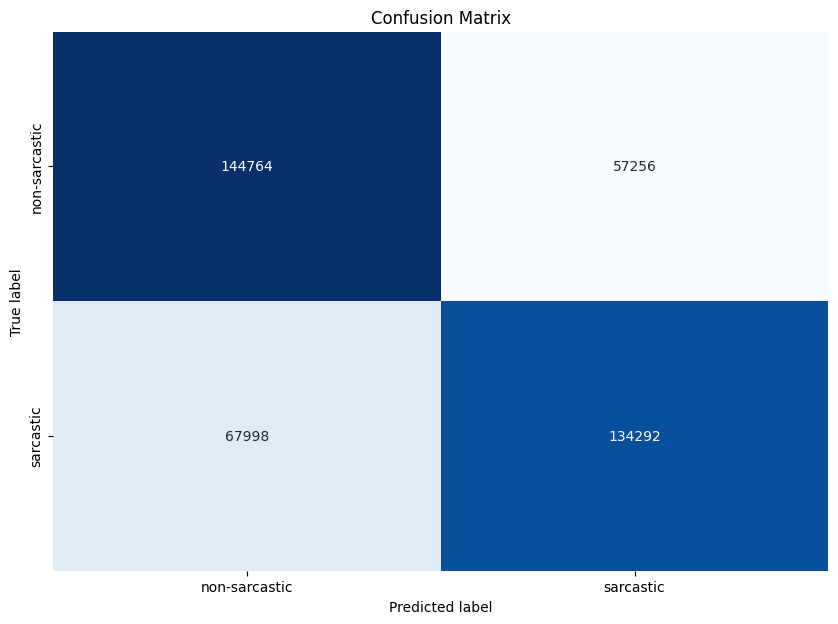

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=cm, cmap='Blues', fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    # Set the axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Set the title
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()
plot_confusion_matrix(y_test, y_pred, ["non-sarcastic", "sarcastic"])

Let's plot the ROC-AUC curve:

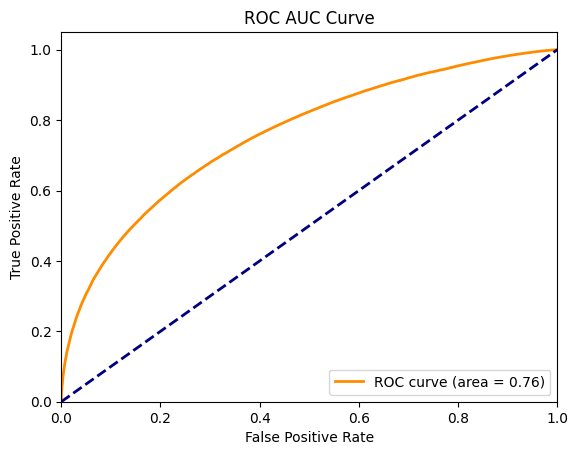

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(y_true, y_pred_proba, title='ROC AUC Curve'):
    # Compute the ROC curve points and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Create the ROC curve plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

plot_roc_auc_curve(y_test, y_pred_proba[:,1])


Lets find the best threshold:

In [38]:
import numpy as np
from sklearn.metrics import roc_curve

def find_best_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate the Youden's J statistic for each threshold
    j_scores = tpr - fpr
    
    # Find the index of the best threshold
    best_threshold_index = np.argmax(j_scores)
    
    # Return the best threshold
    return thresholds[best_threshold_index]

threshold = find_best_threshold(y_test, y_pred_proba[:,1])
threshold

0.5211429846204202

In [51]:
def make_predictions(y_proba) -> int:
    predictions = list()
    for value in y_proba[:,1]:
        if value >= 0.4:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

              precision    recall  f1-score   support

           0       0.72      0.59      0.65    202020
           1       0.65      0.77      0.70    202290

    accuracy                           0.68    404310
   macro avg       0.68      0.68      0.68    404310
weighted avg       0.68      0.68      0.68    404310



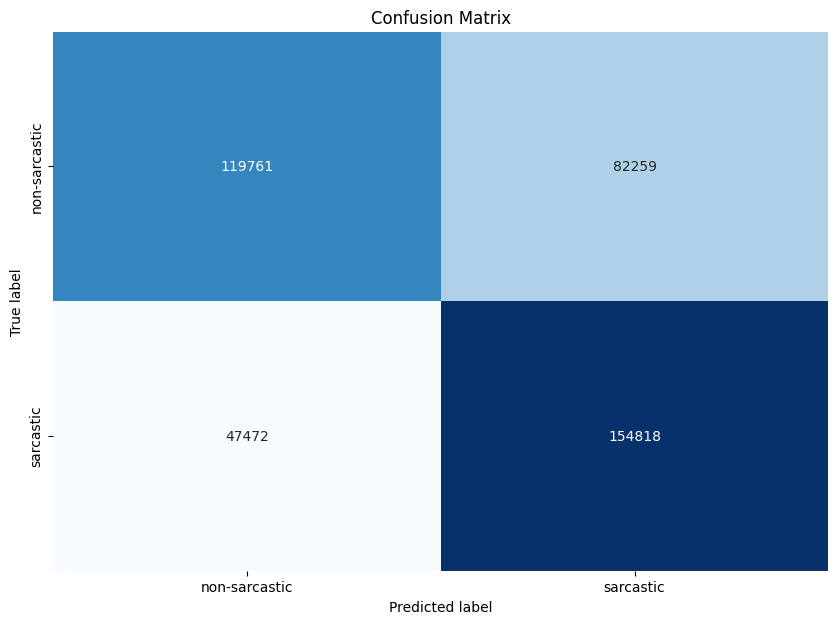

In [52]:
print(classification_report(y_test, make_predictions(y_pred_proba)))
plot_confusion_matrix(y_test, make_predictions(y_pred_proba), ["non-sarcastic", "sarcastic"])

In [56]:
from joblib import dump

dump(mlp, "multilayer_perceptron.joblib")

['multilayer_perceptron.joblib']